In [2]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [12]:
class SPBook:
    def __init__(self,initial_amount,r_daily) -> None:
        self.amount = initial_amount
        self.r_daily = r_daily
        self.i = 0
    def overnight(self):
        self.amount*=  (1+self.r_daily)
        self.i+=1
    def adjust_amout(self,credit:float,debit:float):
        self.amount = self.amount - credit + debit
class WAD:
    def __init__(self,initial_amount,r_daily,price_f,initial_price=1.0) -> None:
        self.amount = initial_amount
        self.p_t = initial_price
        self.P = []
        self.n_wads = self.cal_number_of_coins_from_price(initial_amount,initial_price)
        self.r_daily = r_daily
        self.i = 0
        self.price_f = price_f

    def cal_number_of_coins_from_price(self,amout,price):
        return amout/ price
    
    def mint_burn(self,n_tomint,n_toburn):
        self.n_wads = self.n_wads + n_tomint - n_toburn
    def overnight(self,net_amot,n_tomint=0.0,n_toburn=0.0):
        self.p_t = self.price_f(self.p_t,self.amount,n_tomint,n_toburn,self.r_daily,self.n_wads)
        self.mint_burn(n_tomint,n_toburn)
        self.collect_amount(net_amot)
        self.i+=1
        self.P.append(self.p_t)
    
    def collect_amount(self,amount):
        self.amount = amount


%md
## Yield Expressed in Price $P$



$$P_{t}=\frac{(P_{t-1}+r_{t-1}) \sum_{i=1}^M SP_{t-1,i} + (1+r_{t-1})(M_{t}-B_{t}) }{N_{t-1} + M_{t}-B_{t}}$$

Where:  
$SP_{t, i}:$ 🔴**Initial**🔴 Cash amount blocked with i-th Institutional Service Provider on a day t. 

$P_{\text{t}}:$ Price of a single WAD coin on a day t.

$N_{t}:$ - amount of WADs outstanding on a day t.

$M_t:$ - amount of WADs minted on day t.

$B_t:$ - amount of WADs burned on day t.    

In [4]:


P_t = 1.021

r_annual = 0.0534

AMOUNT_BLOCKED = 5000

NUMBER_OF_WADS = AMOUNT_BLOCKED


N_TOMINT = 20000

N_TO_BURN = 0

r = r_annual / 365



def original_variant(P_t,AMOUNT_BLOCKED,N_TOMINT,N_TO_BURN,r,NUMBER_OF_WADS):
    return ( (1+r)*AMOUNT_BLOCKED + (N_TOMINT-N_TO_BURN) * P_t  ) / (NUMBER_OF_WADS+ N_TOMINT-N_TO_BURN)



#why sum I don't like this formula anymore
def variant1(P_t,AMOUNT_BLOCKED,N_TOMINT,N_TO_BURN,r,NUMBER_OF_WADS):
    return ( (P_t+r)*AMOUNT_BLOCKED + (N_TOMINT-N_TO_BURN) * (1+r)  ) / (NUMBER_OF_WADS+ N_TOMINT-N_TO_BURN)



# P_T = original_variant(P_t,AMOUNT_BLOCKED,N_TOMINT,N_TO_BURN,r,NUMBER_OF_WADS)

P_T = variant1(P_t,AMOUNT_BLOCKED,N_TOMINT,N_TO_BURN,r,NUMBER_OF_WADS)



NEW_AMOT_BLOOCKED = AMOUNT_BLOCKED - N_TO_BURN + N_TOMINT


print(f'Pre transaction WAD price: {P_t}')
print(f'Pre transaction $ amount',P_t * AMOUNT_BLOCKED)

print('-'*10)
print(f'adding {N_TOMINT}; burning: {N_TO_BURN}')
print(f'daily interest on minted: {N_TOMINT * (r)}')
print(f'daily interest on existing: {AMOUNT_BLOCKED * (r)}')
print('-'* 10)
print(f'Post transaction $ amount',P_T * NEW_AMOT_BLOOCKED)
print(f'Post transaction WAD price: {P_T}')

Pre transaction WAD price: 1.021
Pre transaction $ amount 5104.999999999999
----------
adding 20000; burning: 0
daily interest on minted: 2.9260273972602744
daily interest on existing: 0.7315068493150686
----------
Post transaction $ amount 25108.657534246577
Post transaction WAD price: 1.004346301369863


initial amount 25000 simulating for  1000
[1.004492602739726, 1.0046389041095891, 1.0047852054794522, 1.0049315068493152, 1.0050778082191782] 
 [1.1500624657534553, 1.1502087671233183, 1.1503550684931814, 1.1505013698630444, 1.1506476712329075]
SP`s book amount: 28938.314945966824 
WadSet`s book amount: 28766.191780822686


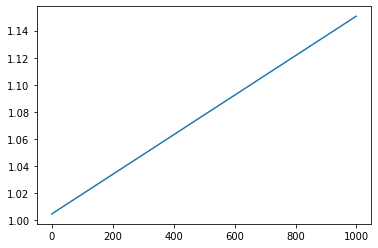

In [5]:
# n = int(np.log(P_t) / np.log(1+r))
n = 1000

prices = list()
P_tt = P_T
N_TOMINT, N_TO_BURN = 0 , 0
NUMBER_OF_WADS = NEW_AMOT_BLOOCKED
spbook = SPBook(NEW_AMOT_BLOOCKED,r_daily=r)

print('initial amount', NEW_AMOT_BLOOCKED,'simulating for ', n)

for t in range(n):
    P_t = variant1(P_tt,NEW_AMOT_BLOOCKED,N_TOMINT,N_TO_BURN,r,NUMBER_OF_WADS)
    prices.append(P_t)
    P_tt = P_t

    spbook.overnight()

AMOUNT_BLOCKED_RES = NEW_AMOT_BLOOCKED * P_t
print(prices[:5],'\n',prices[-5:])
print('SP`s book amount:',spbook.amount,'\nWadSet`s book amount:',AMOUNT_BLOCKED_RES)


X = [t for t in range(n)]
plt.plot(X, prices);

In [6]:
def fit_ols(X,Y):
    X = sm.add_constant(X)

    # Fit the OLS model
    model = sm.OLS(Y, X)
    results = model.fit()

    # Print the summary
    print(results.summary())

fit_ols(X,prices)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                       inf
Date:                Tue, 27 Jun 2023   Prob (F-statistic):               0.00
Time:                        22:10:55   Log-Likelihood:                    inf
No. Observations:                1000   AIC:                              -inf
Df Residuals:                     998   BIC:                              -inf
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0045          0        inf      0.0

c:\Users\ervik\Anaconda3\envs\tda8\lib\site-packages\statsmodels\regression\linear_model.py:1870: RuntimeWarning: divide by zero encountered in double_scalars
  return self.mse_model/self.mse_resid
c:\Users\ervik\Anaconda3\envs\tda8\lib\site-packages\statsmodels\regression\linear_model.py:956: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
c:\Users\ervik\Anaconda3\envs\tda8\lib\site-packages\statsmodels\stats\stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)


%md
## Yield Expressed in Blocked Amount $SP$



$$P_{t}=\frac{(\sum_{i=1}^M SP_{t-1,i} + P_{t-1} M_{t})(1+r_{t-1})- P_{t-1}B_{t} }{N_{t-1} + M_{t}-B_{t}}$$

Where:  
$SP_{t, i}:$ Cash amount blocked with i-th Institutional Service Provider on a day t.

$P_{\text{t}}:$ Price of a single WAD coin on a day t.

$N_{t}:$ - amount of WADs outstanding on a day t.

$M_t:$ - amount of WADs minted on day t.

$B_t:$ - amount of WADs burned on day t.

SOFR rate: 0.05 (daily:0.00013698630136986303) 
 ------------------------------
T0:amount:10000:,number:10000.0,;price:,1.0
----------
	SP0 amount EOD: 10001.369863013699
T1:amount:10001.369863013699:,number:10000.0,;price:,1.0001369863013698
----------
	SP0 amount EOD: 10002.739913679865
T2:amount:10002.739913679865:,number:10000.0,;price:,1.0002739913679866
----------
	SP0 amount EOD: 10004.110152024205
T3:amount:10004.110152024205:,number:10000.0,;price:,1.0004110152024204
----------
	SP0 amount EOD: 10005.480578072427
T4:amount:10005.480578072427:,number:10000.0,;price:,1.0005480578072428
----------
	SP0 amount EOD: 10006.851191850245
T5:amount:10006.851191850245:,number:10000.0,;price:,1.0006851191850243
----------
	SP0 amount EOD: 10008.221993383375
T6:amount:10008.221993383375:,number:10000.0,;price:,1.0008221993383375
----------
	SP0 amount EOD: 10009.592982697537
T7:amount:10009.592982697537:,number:10000.0,;price:,1.0009592982697537
----------
	SP0 amount EOD: 10010.964159818

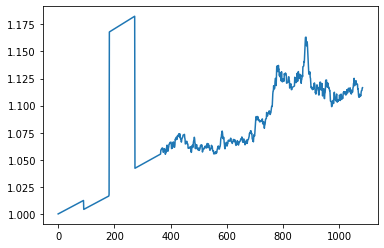

In [34]:
from typing import List
'''


If no mint/burin then 

P_t = P_{t-1} * (1+r_{t-1}) 

P_t = sum(SP) / N_t


if burn/mint - smooth between old price and new price.

remove parameters 
P_t = ((SP_TOTAL_CASH + CASH_TO_MINT) * (1+r) - WADS_TO_BURN * P_t) / (NUMBER_OF_WADS + (CASH_TO_MINT/P_{t-1}) - WADS_TO_BURN)

NUMBER_OF_WADS_TO_MINT = CASH_TO_MINT/P_{t-1}

NUMBER_OF_WADS = NUMBER_OF_WADS_{t-1}  +NUMBER_OF_WADS_TO_MINT - WADS_TO_BURN

~~~
SP_TOTAL_CASH = Pt * NUMBER_OF_WADS
~~~



- add comision
- add price of buring 
- 

'''
def variant2(P_t,AMOUNT_BLOCKED,N_TOMINT,N_TO_BURN,r,NUMBER_OF_WADS):
    return  ((AMOUNT_BLOCKED + N_TOMINT * P_t) * (1+r) - N_TO_BURN * P_t) / (NUMBER_OF_WADS + N_TOMINT - N_TO_BURN)


def run_overnight(wad_network:WAD,SPs:List[SPBook],N_TOMINT:int=0.0,N_TO_BURN:int=0.0):
    print('-'*10)
    total_SP_amnt = 0

    #First: in the "morning" collect overnight accross SPs
    for i,SP in enumerate(SPs):
        SP.overnight()
        SP.adjust_amout(credit=N_TO_BURN,debit=N_TOMINT)
        total_SP_amnt+=SP.amount
        print(f'\tSP{i} amount EOD:',SP.amount)
    
    #Then the network calculates 
    wad_network.overnight(net_amot=total_SP_amnt,n_tomint=N_TOMINT,n_toburn=N_TO_BURN)
    print(f'T{wad_network.i}:amount:{wad_network.amount}:,number:{wad_network.n_wads},;price:,{wad_network.p_t}')

run_days = 90
r_annual = 0.05
r = r_annual / 365    
print(f'SOFR rate: {r_annual} (daily:{r})','\n','-'*30)





P_t = 1.
INITIAL_MINTED = 10000
spbook0 = SPBook(INITIAL_MINTED,r_daily=r)
wad_network = WAD(initial_amount=INITIAL_MINTED,r_daily=r,price_f=variant2,initial_price=P_t)

#Both amount blocked and number of WADs are the function of initial minted amount and price
AMOUNT_BLOCKED_T0 = 5000 * P_t
NUMBER_OF_WADS_T0 = AMOUNT_BLOCKED_T0 / P_t


print(f'T0:amount:{wad_network.amount}:,number:{wad_network.n_wads},;price:,{wad_network.p_t}')

for i in range(run_days):
    run_overnight(wad_network,SPs=[spbook0])


#ADD more 
N_TOMINT0 = INITIAL_MINTED * 2
N_TO_BURN0 = 0
print(f'will mint:{N_TOMINT0},will burn:{N_TO_BURN0}')
run_overnight(wad_network,SPs=[spbook0],N_TOMINT=N_TOMINT0,N_TO_BURN=N_TO_BURN0)


for i in range(run_days):
    run_overnight(wad_network,SPs=[spbook0])
    


#Remove amlost all
N_TOMINT1 = 0
N_TO_BURN1 = (INITIAL_MINTED + N_TOMINT0) * .9
print(f'will mint:{N_TOMINT1},will burn:{N_TO_BURN1}')
run_overnight(wad_network,SPs=[spbook0],N_TOMINT=N_TOMINT1,N_TO_BURN=N_TO_BURN1)

for i in range(run_days):
    run_overnight(wad_network,SPs=[spbook0])


#restore initial amount
N_TOMINT2 = INITIAL_MINTED
N_TO_BURN2 = 0
print(f'will mint:{N_TOMINT1},will burn:{N_TO_BURN1}')
run_overnight(wad_network,SPs=[spbook0],N_TOMINT=N_TOMINT2,N_TO_BURN=N_TO_BURN2)

for i in range(run_days):
    run_overnight(wad_network,SPs=[spbook0])
    



#random withdrawl/deposit

import random
AMOUNT_TT = wad_network.amount
days_multpl = 8
p_mint_burn_event = 0.3
for i in range(run_days*days_multpl):
    if random.random() >p_mint_burn_event:
        N_TOMINT_TT = AMOUNT_TT * random.uniform(0.01,0.10)
        N_TO_BURN2_TT = AMOUNT_TT * random.uniform(0.01,0.10)

        print(f'will mint:{N_TOMINT_TT},will burn:{N_TO_BURN2_TT}')
        run_overnight(wad_network,SPs=[spbook0],N_TOMINT=N_TOMINT_TT,N_TO_BURN=N_TO_BURN2_TT)
    else:
        run_overnight(wad_network,SPs=[spbook0])





X , P = [t for t in range(wad_network.i)],wad_network.P
plt.plot(X, P);
fit_ols(X,P)

In [ ]:


# P_T = variant2(P_t,AMOUNT_BLOCKED_T,N_TOMINT,N_TO_BURN,r,NUMBER_OF_WADS_T)



# NEW_AMOT_BLOOCKED = AMOUNT_BLOCKED_T - N_TO_BURN + N_TOMINT


# print(f'Pre transaction WAD price: {P_t}')
# print(f'Pre transaction $ amount',P_t * AMOUNT_BLOCKED)

# print('-'*10)
# print(f'adding {N_TOMINT}; burning: {N_TO_BURN}')
# print(f'daily interest on minted: {N_TOMINT * (r)}')
# print(f'daily interest on existing: {AMOUNT_BLOCKED * (r)}')
# print('-'* 10)
# print(f'Post transaction $ amount',P_T * NEW_AMOT_BLOOCKED)
# print(f'Post transaction WAD price: {P_T}')


In [9]:
NEW_AMOT_BLOOCKED_T = P_T * NEW_AMOT_BLOOCKED
NEW_AMOT_BLOOCKED_T

25108.657534246577

[1.005171791480578, 1.0059979600763154, 1.0068248077147341, 1.0076523349539517, 1.008480542352544] 
 [2.276480890134077, 2.2783519703177486, 2.2802245883755443, 2.282098745571469, 2.283974443170569]
SP`s book amount: 57099.36107926433 
WadSet`s book amount: 57300.43586188772


ValueError: endog and exog matrices are different sizes

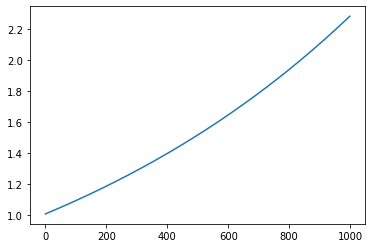

In [10]:
# n = int(np.log(P_t) / np.log(1+r))
n = 1000

prices = list()
P_tt = P_T
N_TOMINT, N_TO_BURN = 0 , 0
NUMBER_OF_WADS = NEW_AMOT_BLOOCKED

spbook = SPBook(NEW_AMOT_BLOOCKED_T,r_daily=r)

for t in range(n):
    AMOUNT_BLOCKED_T = NEW_AMOT_BLOOCKED_T * P_tt
    NUMBER_OF_WADS_T = AMOUNT_BLOCKED_T / P_tt

    P_t = variant2(P_t,AMOUNT_BLOCKED_T,N_TOMINT,N_TO_BURN,r,NUMBER_OF_WADS_T)
    prices.append(P_t)
    P_tt = P_t

    spbook.overnight()

print(prices[:5],'\n',prices[-5:])

print('SP`s book amount:',spbook.amount,'\nWadSet`s book amount:',AMOUNT_BLOCKED_T)


plt.plot([t for t in range(n)], prices);

fit_ols(X,prices)

30170.89936881009